# Глубинное обучение для текстовых данных, ФКН ВШЭ
## Домашнее задание 5: Retrieval‑Augmented Generation (RAG)
### Оценивание и штрафы

Максимально допустимая оценка за работу — __10 баллов__.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Весь код должен быть написан самостоятельно. Чужим кодом для пользоваться запрещается даже с указанием ссылки на источник. В разумных рамках, конечно. Взять пару очевидных строчек кода для реализации какого-то небольшого функционала можно.

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

__Мягкий дедлайн 16.12.24 23:59__ \
__Жесткий дедлайн 19.12.24 23:59__

### О задании

В этом домашнем задании вам предлагается реализовать ассистента для кулинарных советов с помощью RAG, который помимо всего прочего может ходить в итернет за дополнительной информацией. Всю логику системы нужно будет написать самостоятельно без специализорованных библиотек. Мы разделили ее на несколько логических компонент, каждой из которых будет отведено отдельное задание:
1. Векторная база данных с быстрым семантическим поиском
2. Разбиение текстов на куски.
3. Ранжирование документов по релевантности
4. Формирование контекста для модели и генерация ответа

### О данных

В качестве базы данных мы будем использовать пользовательские рецепты с сайта "Поваренок.Ру". Они получены с помощью веб-парсинга сайта, поэтому местами тексты недостаточно чистые. Всего в датасете содержится 84130 рецептов.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os

os.chdir('/content/drive/MyDrive/DL/NLP_HSE (YSDA)/RAG')

### Загрузка датасета и модели

Таблица с рецептами хранится в файле `povarenok.csv`. Каждая запись содержит название рецепта, список ингредиентов и сам рецепт. Несмотря на то, что всего датасете хранится 84130 записей, в рамках этого задания мы будем работать с первыми 10-ю тысячами для того, чтобы все работало быстрее. При желании вы можете взять больше.

In [3]:
!pip install -U -q datasets
!pip install -U -q huggingface_hub
!pip install -q jaxtyping

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.8/494.8 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 15.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12 12.5.82 which is incompatible.
torch 2.6

In [4]:
from datasets import load_dataset
import shutil

shutil.rmtree('/root/.cache/huggingface', ignore_errors=True)
os.makedirs('/content/dataset_cache', exist_ok=True)
dataset = load_dataset(
    'csv',
    data_files=['povarenok.csv'],
    split='train',
    cache_dir="/content/dataset_cache",
    download_mode="reuse_cache_if_exists"
)

Generating train split: 0 examples [00:00, ? examples/s]

In [5]:
dataset = dataset.select(range(10000))

In [6]:
dataset[0]

{'name': 'Густой молочно-клубничный коктейль',
 'ingredients': "['Молоко', 'Клубника', 'Сахар']",
 'text': 'Не размораживая, ягоду положите в блендер, добавьте молоко и сахар (если ягода свежая, то и перепелиное яйцо) Взбивайте на высокой скорости до полного измельчения ягод. Вылете в стаканы и можно по чуть-чуть пить, так как этот напиток оочень холодный. Кто не любит таковой, подождите и выпейте, когда он немного согреется. Приятного аппетита!'}

Посмотрим на распределение длин текстов. Нам важно знать с чем мы имеем дело, ведь RAG подразумевает, что мы будем подавать тексты на вход модели.

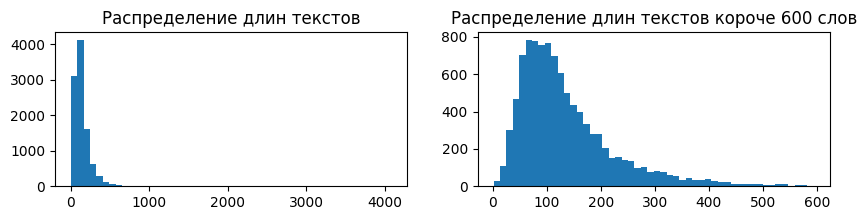

In [7]:
lens = np.array([len(dataset[i]['text'].split()) for i in range(len(dataset))])

plt.figure(figsize=(10, 2))
plt.subplot(1, 2, 1)
plt.hist(lens, bins=50)
plt.title('Распределение длин текстов')

plt.subplot(1, 2, 2)
plt.hist(lens[lens < 600], bins=50)
plt.title('Распределение длин текстов короче 600 слов')

plt.show()

Видим, что тексты часто довольно длинные. Поэтому смухлевать не получится и перед векторизацией нужно будет разбивать каждый текст на небольшие куски, чтобы не перегружать контекст модели и чтобы потерять важную информацию при векторизацци текстов на этапе складывания их в векторную базу данных.

Приступим к реализации RAG.

## Retrieval‑Augmented Generation

В качестве основы для ассистента возьмите модель [`Qwen/Qwen2-1.5B-Instruct`](https://huggingface.co/Qwen/Qwen2-1.5B-Instruct) из huggingface. Важно, что это `Instruct` модель, то есть она предлазначена для общения в формате диалога.

__Задание 0 (0 баллов).__ Проверьте, как модель отвечает на кулинарные вопросы без RAG. Это необходимо сделать, чтобы понять, нужен ли вообще RAG для данной задачи.

In [8]:
from transformers import pipeline
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

baseline_pipeline = pipeline(
    "text-generation",
    model="RefalMachine/ruadapt_qwen2.5_3B_ext_u48_instruct_v4",
    device=device,
    torch_dtype=torch.float16
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/777 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/195 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/12.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/605 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/759 [00:00<?, ?B/s]

Device set to use cuda


In [9]:
messages = [
    {"role": "system", "content": "Ты полезный и дружебленый помощник, который специализируется на кулинарных рецептах. Для каждого рецепта возвращай полноценный ответ с указанием списка необходимых продуктов и подробной инструкцией приготовления"},
    {"role": "user", "content": "Предложи полезное блюдо на ужин для набора массы"}
]

output = baseline_pipeline(messages, max_new_tokens=512, do_sample=True, temperature=0.5, top_p=0.9)
print(output[0]['generated_text'][-1]['content'])

Для набора массы важно сочетать качественную белковую пищу с достаточными энергетическими источниками, чтобы обеспечить быстрый рост мышечной массы. Вот простой и полезный рецепт ужина, который поможет вам в этом:

### Рецепт: Свинина с овощами и гречневой кашей

#### Ингредиенты:
- 500 г свинины (лучше нежирной)
- 3 средних моркови
- 2 кабачка среднего размера
- 1 большой лук
- 1 большая луковица
- 1 стакан гречневой крупы
- 2 стакана воды или бульона
- 2 столовые ложки оливкового масла
- 1 чайная ложка соли
- 1/2 чайной ложки черного молотого перца
- Зелень укропа или петрушки (по желанию)

#### Инструкция по приготовлению:

1. **Подготовка ингредиентов**:
   - Нарежьте мясо небольшими кусочками и обжарьте его на сковорке с оливковым маслом до золотистого цвета.
   - Очистите морковь и кабачок, порубите их на небольшие кусочки и обжарьте вместе с луком и луком в сковорке до мягкости.

2. **Приготовление гречневой каши**:
   - В кастрюле соедините воду или бульон с солью и черным перц

### Locality Sensitive Hashing (LSH)

В RAG для каждого запроса необходимо искать релевантные документы по векторной базе данных. Так как документов очень много, подсчет релевантности для каждого из них будет занимать очень много времени. Поэтому нам важно, чтобы поиск был быстрым. Для достижения этого мы даже готовы немного пожертвовать точностью.

В этой секции вам предстоит реализовать [Locality Sensitive Hashing](https://ru.wikipedia.org/wiki/Locality-sensitive_hashing).

Идея LSH довольна проста. Разделим все векторы из базы данных на группы, состоящие из похожих векторов. В начале поиска определим группу, которая соответствует вектору запроса и будем считать релевантность только для объектов из этой группы. Для разбиения на группы мы введем несколько хеш-функций. Каждая их них будет строиться по следующему алгоритму:
1. Сгенерируем $k$ случайных векторов (векторы нормали гиперплоскости)
2. Для отдельной точки (вектора) в базе данных и вектора нормали запишем 1, если точка лежит над соответствующей гиперплоскостью. В обратном случае запишем 0.
3. Повторим процедуру для всех точек и векторов нормали. Так мы для каждой точки получим список из $k$ 0 и 1, который и будет хешем.
4. Запишем в хеш-таблицу найденные точки для каждого хеша.
5. Повторим шаги 1-4 $L$ раз и получим $L$ разных хеш-таблиц.

Теперь для каждого нового вектора $q$ мы можем очень быстро найти набор векторов похожих на него. Для этого посчитаем хеши запроса в каждой хеш-таблице и возьмем все точки, у которых хеш совпал c $q$ хотя бы в одной из них. Затем переранжируем найденные точки по релевантности (расстоянию до вектора запроса) и оставим заданное число самых близких.

Сложность формирования хеш-таблиц можно оценить как $O(nLkd)$, где $n$ – число векторов в базе данных, а $d$ – размерность вектора. В то же время сложность поиска LSH – $O(Lkd + (nLp) \cdot d)$, где $p$ – вероятность того, что хеш двух случайных точек совпадет ($p$ стремится к 0). Сложность полного перебора – $O(nd)$, поэтому при поиске LSH работает быстрее почти в $\frac{n}{Lk}$ раз!

__Задание 1 (3 балла).__ Реализуйте векторную базу данных LSH поиском. База данных должна уметь добавлять новые векторы, а так же по входному вектору быстро находить ближайшие к нему. Во время создании базы данных сгенерируйте необходимое число хеш-функций. Подумайте о том, как выбрать количество хеш-таблиц и число случайных векторов, а так же о том, из какого распределения брать эти случайные векторы. При добавлении нового вектора в базу данных, считайте для него хеш и записывайте, каким группам от принадлежит.

### Разбиение текста на куски

Так как некоторые тексты довольно длинные, если мы будем кодировать их целиком одним вектором, то часть информации потеряется. Вектор все таки имеет ограниченный размер. Чтобы не терять информацию, мы поделим текст на куски и будем кодировать каждый кусок отдельно.

__Задание 2 (2 балла).__ Реализуйте [рекурсивное разбиение](https://dev.to/eteimz/understanding-langchains-recursivecharactertextsplitter-2846) текста с уровнями `["\n\n", "\n", " ", ""]`. Добавьте пересечение между кусками для уровней `[" ", ""]`. То есть если целый абзац помещается в один кусок, то пересекать его ни с чем не надо (в нем содержится законченная мысль), а если абзац не влезает и его приходится делить по словам (или символам), то нужно добавить пересечение со словами из соседних кусков того же абзаца.

Значения для максимального размера каждого куска и длины пересечения выберите самостоятельно. Надежнее всего брать размер пересечения равным половине длины куска.

## RAG

Наконец мы можем начать собирать систему RAG. Для начала соберем векторую базу данных из кусков рецептов. Для получения эмбеддингов текстов возьмите модель [`intfloat/multilingual-e5-large`](https://huggingface.co/intfloat/multilingual-e5-large), она создана специально для этой задачи и хорошо работает с русским языком.

__Задание 3 (1 балл).__ Соберите векторую базу данных с помощью написанных вами функций. Процесс не должен занимать много времени с GPU, но мы рекомендуем сохранить результат на диск, чтобы не векторизовать весь датасет заново при перезапуске ядра. Проверьте, что по запросу возвращаются релевантные тексты.

In [10]:
from sentence_transformers import SentenceTransformer
import torch

embedding_model = SentenceTransformer("intfloat/multilingual-e5-large", model_kwargs={'torch_dtype': torch.float16})

modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/201 [00:00<?, ?B/s]

In [11]:
from db_creation import create_database, semantic_search

my_db = create_database(dataset, embedding_model, 256, 128)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Batches:   0%|          | 0/138 [00:00<?, ?it/s]

Batches:   0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/70636 [00:00<?, ?it/s]

In [12]:
query = "Клубничный молочный коктейль"
output = semantic_search(my_db, query, embedding_model, limit=4)

In [13]:
for recipe in output:
    print(f"Название рецепта: {recipe[2]['name']}, Сходство: {recipe[1]:.3f}")
    print(f"Ингредиенты: {recipe[2]['ingredients']}")
    print(f"Чанк рецепта:")
    print(f"{recipe[2]['text']}")
    print("\n" + "-" * 50 + "\n")

Название рецепта: Густой молочно-клубничный коктейль, Сходство: 0.932
Ингредиенты: ['Молоко', 'Клубника', 'Сахар']
Чанк рецепта:
Не размораживая, ягоду положите в блендер, добавьте молоко и сахар (если ягода свежая, то и перепелиное яйцо) Взбивайте на высокой скорости до полного измельчения ягод. Вылете в стаканы и можно по чуть-чуть пить, так как этот напиток оочень холодный. Кто

--------------------------------------------------

Название рецепта: Густой молочно-клубничный коктейль, Сходство: 0.927
Ингредиенты: ['Молоко', 'Клубника', 'Сахар']
Чанк рецепта:
скорости до полного измельчения ягод. Вылете в стаканы и можно по чуть-чуть пить, так как этот напиток оочень холодный. Кто не любит таковой, подождите и выпейте, когда он немного согреется. Приятного аппетита!

--------------------------------------------------

Название рецепта: Клубнично-лаймовый коктейль, Сходство: 0.925
Ингредиенты: ['Клубника', 'Лайм', 'Сахар коричневый', 'Вода газированная']
Чанк рецепта:
Для приготовления 

### Формирование контекста для модели и генерация ответа

Из всех компонент RAG эта самая творческая. Надо придумать промпт, который будет лучше всего помогать модели генерировать ответ.

__Задание 4 (1 балл).__ Напишите функцию для генерации ответа по текстовому запросу в парадигме RAG. Найдите релевантные документы и соберите из них промпт, объяснив дополнительно модели, что от нее требуется. Количество текстов в промпте ограничивайте отбирая топ самых релевантных. Заметьте, что в нашем датасете помимо рецепта есть список ингредиентов и название блюда. Подумайте о том, как можно их использовать. Предайте промпт в модель для получения ответа. Подберите гиперпараметры генерации, чтобы контролировать разнообразие. Помните, что модель должна строго соответствовать инструкциям, не придумывать факты и не генерировать то, что от нее не требуется. Продемонстрируйте ваши результаты на 3-5 примерах.

In [14]:
from RAGModel import RAGmodel

model = RAGmodel(baseline_pipeline, embedding_model, my_db)

In [15]:
query = "Как приготовить квас?"
print(model.generate_recipe(query))

Приветствую! Готовить квас довольно просто и легко. Для начала возьмите свежий хлеб, который лучше всего использовать хлеб с корочкой. Также понадобится солод, вода, закваска и сахар.

### Ингредиенты:
- Свежий хлеб — 100 г
- Солод — 50 г
- Вода — 500 мл
- Закваска — 1 столовая ложка
- Сахар — 2 столовые ложки (по желанию)

### Инструкция по приготовлению:

1. **Подготовка ингредиентов**: Очистите хлеб от корочки, замочите его в воде на несколько часов, чтобы извлечь влагу и сделать его более мягким. Солод также промойте и просушите.

2. **Приготовление раствора для закваски**: В кастрюле смешайте воду с сахаром и нагрейте до закипания, но не доводите до кипения. Добавьте измельченный солод и закваску, перемешайте и остудите до комнатной температуры.

3. **Добавление хлеба к закваске**: После остывания добавьте размоченный хлеб в приготовленную смесь. Замесите тесто, которое должно быть густым и тягучим.

4. **Выделение газа**: Смесь поместите в кастрюлю и накрой крышкой. Оставьте её н

In [16]:
query = "Подскажи рецепт ужина для набора массы"
print(model.generate_recipe(query))

Приветствую! 

Приготовьте себе вкусное и питательное сытное блюдо для набора массы с рецептом быстрого ужина «Ужин "Мужнина радость"». 

Ингредиенты:
- Курица, 400 г;
- Чеснок, 2 зубчика;
- Картофель, 1 крупный;
- Масло растительное, 2 столовые ложки;
- Мед, 1 столовая ложка;
- Специи: черный перец, кориандр, лавровый лист;
- Яйцо куриное, 1 штука;
- Ветчина, 100 г (по желанию);
- Огурец, 1 шт., без кожицы;
- Майонез, 1/2 стакана;
- Сок томатный, 1 чашка;
- Зелень укропа или петрушки для украшения (по вкусу).

Приготовление:
1. **Курица**:
   - Курицу промойте, обсушите бумажным полотенцем и разделите на филе по 250 г.
   - Нарежьте куриные филе на небольшие кусочки.
   - Разомните два зубчика чеснока и добавьте его в фарш курицы. Посолите и поперчите по вкусу.
   - Взбейте яичную смесь с яйцом и добавьте к курице.

2. **Картофель**:
   - Очистите картофель от кожицы и натрите на крупной терке.
   - Обжарьте на сковороде сливочное масло до золотистого цвета, затем добавьте мелко нарез

In [21]:
query = "рецепт дуриана"
print(model.generate_recipe(query))

Приветствую! 

Не нашёл для вас готового рецепта дуриана здесь. Возможно, вы имеете в виду другое блюдо или название? 

Если вы ищете рецепт чего-то похожего или сходного с дарианом, может быть, вам подойдет рецепт "Крабовые палочки с кокосовым соусом"? Это блюдо также связано с экзотическими ингредиентами, такими как кокос и крабы, и требует аккуратности при приготовлении. 

Если вы хотите приготовить что-то похожее на дариан, возможно, стоит поискать рецепты десертов или сладостей с использованием таких экзотических фруктов, как ананас или авокадо, а также добавление специй и орехов. 

Пожалуйста, уточните ваш запрос, и я постараюсь помочь с более конкретным рецептом.


In [22]:
query = "как приготовить кашу из топора?"
print(model.generate_recipe(query))

Приветствую! 

Извините за путаницу, но у нас нет рецепта для приготовления "каши из топора". Возможно, вы имели в виду запеканку из топора, которая использует картофель, тунец, чеснок, соевый соус, укроп, сливки, смесь перцев, масло оливковое, пармезан, соль, грибы и курицу. 

Запеканка из топора выглядит так:
1. Картофель нарезаем кружочками, варим, остужаем, очищаем.
2. Курицу нарезаем тонкими полосками, добавляем укроп и соевый соус, тщательно перемешиваем.
3. Грибы мелко нарезаем, обжариваем в оливковом масле до золотистого цвета.
4. На противень равномерно расстилаем слоями: картошка, курица с укропом, грибы и вновь картошка. Посоляем, приправляем специями.
5. Останавливаем духовку на среднем огне, накрываем крышкой и тушим около 30 минут.
6. Готовность проверяется при помощи деревянной палочки, она должна легко пройти через слой запекания без остатка теста.

Если же вы имеете в виду что-то другое, уточните пожалуйста, и я постараюсь помочь с более точным рецептом. Спасибо за пон

In [19]:
query = "Рецепт свиных крылышек в соусе барбекю"
print(model.generate_recipe(query))

Приветствую! Для приготовления свиных крылышек в соусе барбекю предлагаю вам следующий простой и вкусный рецепт.

### Краткое описание блюда:
Свиные крылышки в соусе барбекю — это сочные и аппетитные кусочки мяса, обжаренные в ароматном барбекю-соусе с добавлением специй, перца и меда.

### Ингредиенты:
- Свиные крылышки — 6 штук
- Растительное масло — 2 столовые ложки
- Молотый черный перец — 1/2 чайной ложки
- Сухой чеснок — 1 зубчик
- Томаты (сваренные) — 2 штуки
- Соевый соус — 1 столовая ложка
- Сахар — 1 столовая ложка
- Вода — 1 стакан
- Зелень укропа — для подачи (по желанию)

### Пошаговая инструкция приготовления:

1. **Подготовка крылышек**:
   - Свиные крылышки тщательно промойте под проточной водой.
   - Нарежьте крылышки на небольшие кусочки примерно 1,5 см в диаметре.
   - Посолите и поперчите каждую часть крылышек.

2. **Подготовка соуса**:
   - В кастрюле смешайте томаты, сок сваренных томатов, сахар, соевый соус, соль и немного воды (примерно 1 стакан).
   - Варите со

__Бонус [история] (1 балл)__. Важный недостаток текущего подхода заключается в том, что ассистенту нельзя задавать уточняющие вопросы по его же ответам. Приходится переписывать весь запрос целиком, добавляя больше деталей. Это, в целом, решение, но будет лучше, если в системе будет сохраняться история общения, а затем использоваться при генерации нового ответа. В этом задании вам предлагается добавить этот функционал.

Существует много способов встраивания истории в модель. Например, можно просто сохранить все вопросы и ответы и подавать их в контекст. Однако такой способ значительно увеличит размер промпта, из-за чего увеличатся затраты по времени и памяти на каждый ответ. Конечно, можно попробовать фильтровывать историю, оставляя только те запросы и ответы, которые касаются текущего запроса. Тем не менее, это все еще будет перегружать промпт. Поэтому есть подход куда лучше.   
Перед поиском релевантных текстов попросим модель переформулировать полученный запрос так, чтобы он стал более полным и включал в себя контекст предыдущего общения. Например, `"Какая у него каллорийность?" -> "Какая каллорийность у салата Цезарь?"`. С таким новым запросом мы сможем искать релевантные тексты с учетом истории, не увеличивая итоговый размер промпта.

Реализуйте описанную схему. Для переформулирования запроса используйте ту же модель, что и для генерации, и убедитесь, что она хорошо справляется со своей задачей. С какими сложностями вы столкнулись?

In [28]:
from history_RAG import RAG_with_history

history_model = RAG_with_history(
    rag_model=model,
    paraphrase_model=baseline_pipeline
)

history_model.start_conversation()

Начат новый разговор с ассистентом. Предыдущая история запросов удалена


In [29]:
query_0 = "Как приготовить куриный суп?"
print(history_model.ask_question(query_0))

Приветствую! Готовить куриный суп можно по нескольким отличным рецептам. Вот один из них, который подойдет для любителей вкусного и питательного блюда:

### Куриный суп с зеленым горошком

#### Ингредиенты:
- Грудка куриная – 400 г
- Морковь – 1 штука
- Картофель – 2 штуки
- Горошек зеленый – 1 банка
- Лук репчатый – 1 штука
- Соль – по вкусу
- Специи (на ваш выбор): перец черный, кориандр, петрушка
- Лист лавровый
- Зелень (укроп, петрушка) для подачи

#### Пошаговая инструкция приготовления:
1. **Подготовка продуктов**: Очистите грудку куриную от пленок и жира. Нарежьте ее на небольшие кусочки. Морковь и картофель тщательно промойте, очистите от кожицы и нарежьте кубиками. Лук мелко нашинкуйте.

2. **Подготовка овощей**: Лук пропельте в сковороде до золотистого цвета, затем добавьте морковь и картошку. Перемешайте и продолжайте тушить до мягкости.

3. **Подготовка бульона**: В большой кастрюле или сковороде залейте подготовленные овощи водой и добавьте кусок листа лаврового дерева. Д

In [30]:
query_1 = "Какая у него калорийность?"
print(history_model.ask_question(query_1))

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Приветствую! Давайте разбираться с калорийностью куриного супа с зеленым горошком, который мы приготовим по вашему рецепту.

### Ингредиенты (по 1 порции):
- Грудка куриная — 150 г
- Морковь — 1 шт.
- Картофель — 1 шт.
- Зеленый горошек — 100 г
- Лук репчатый — 1 шт.
- Соль — по вкусу
- Специи — по вкусу
- Листья лавровых — 1 штука
- Зелень — по желанию
- Вода — для бульона

### Калорийность (в среднем):
- Грудка куриная содержит примерно 140 ккал за 100 г;
- Морковь — 20-30 ккал за 100 г;
- Картофель — 70-80 ккал за 100 г;
- Зеленый горошек — 20 ккал за 100 г;
- Лук — около 20 ккал за 100 г;
- Листья лавровые — примерно 10 ккал за штуку;
- Зелень — около 10 ккал за 100 г.

Таким образом, общая калорийность одного порция (примерно 500 г) куриного супа с зеленым горошком составит около **350-400 ккал**. Это довольно умеренная калорийность, подходящей как для похудения, так и для поддержания нормального веса при разумной дозировке.

### Пошаговая инструкция приготовления:

#### Шаг 1: По

In [34]:
query_2 = "Сколько белков, жиров и углеводов содержит этот рецепт?"
print(history_model.ask_question(query_2))

Привет! Готовы к тому, чтобы улучшить свой ужин или перекус? Давайте разберемся, как сделать куриный суп с зеленым горошком более питательным!

### Калорийность и Добавки

Ваш базовый рецепт куриного супа с зеленым горошком уже содержит полезные компоненты, такие как мясо курицы, овощи (морковь и картофель) и зелень. Однако, для увеличения питательности и калорийности можно добавить следующие ингредиенты:

1. **Молочные добавки**: К примеру, сливки или молоко помогут увеличить количество жиров и увеличить калорийность блюда. Это особенно полезно для тех, кто хочет получить больше энергии после ужина.

2. **Оливковое масло**: Добавьте немного оливкового масла для дополнительного содержания здоровых жирных кислот, таких как омега-3, что также способствует улучшению здоровья сердца.

3. **Зелёные соусы**: Добавление таких продуктов, как соуса из свежей капусты или зеленого горошка, может добавить больше витаминов и минералов.

4. **Добавки витаминизированные**: Например, можно включить в 

In [35]:
print("Перефразированные вопросы")
for key, answer in history_model.chat_history.history.items():
    print(f"Вопрос {key}: {answer['query']}")

Перефразированные вопросы
Вопрос 0: Как приготовить куриный суп?
Вопрос 1: Какова калорийность куриного супа с зеленым горошком, приготовленного по вашему рецепту?
Вопрос 2: Какова калорийность куриного супа с зеленым горошком, приготовленного по вашему рецепту, и какие добавки могут повысить его питательность?


Видим, что появляются дополнительные проблемы из-за использования модели для перефразирования, которая не идеально справляется со своей задачей